In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [141]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'drive/MyDrive/colab/final_nba_data.csv'
df = pd.read_csv(file_path, encoding='cp949', sep=',')

# Clean column names
df.columns = df.columns.str.strip()

# Example salary cap data
salary_cap_data = {
    'year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'salary_cap': [70000000, 94143000, 99093000, 101869000, 109140000, 109140000, 112414000, 112414000, 119025000, 119025000]
}
salary_cap_df = pd.DataFrame(salary_cap_data)

stats_columns = df.columns[8:]  # Assuming stats start from the 'Pos' column onwards
df = df.dropna(subset=stats_columns)

# Filter data for the desired years
df = df[(df['start'] > 2014) & (df['start'] < 2025)]

# Determine the salary cap based on the start year of each contract
df['salary'] = df.apply(lambda x: x['salary'] / salary_cap_df.set_index('year').loc[x['start'], 'salary_cap'], axis=1)

In [142]:
contract_data = []

for i in range(1, len(df)):
    current_contract = df.iloc[i]
    past_contract = df.iloc[i - 1]

    if current_contract['name'] == past_contract['name']:
        debut_diff = current_contract['start'] - current_contract['debut']  # 경력 계산
        past_stats = past_contract[stats_columns]  # 이전 계약의 통계 데이터 가져오기
        current_salary_to_cap = current_contract['salary'] / salary_cap_df.set_index('year').loc[current_contract['start'], 'salary_cap']
        contract_data.append({
            'name': current_contract['name'],
            'debut_diff': debut_diff,  # 경력 추가
            'past_salary': past_contract['salary'],
            'past_salary_cap': salary_cap_df.set_index('year').loc[past_contract['start'], 'salary_cap'],
            'current_salary': current_contract['salary'],
            'current_salary_cap': salary_cap_df.set_index('year').loc[current_contract['start'], 'salary_cap'],
            'past_salary_to_cap': past_contract['salary'] / salary_cap_df.set_index('year').loc[past_contract['start'], 'salary_cap'],
            'current_salary_to_cap': current_salary_to_cap,
            'current_contract_year': current_contract['start'],
            'past_contract_year': past_contract['start'],
            'past_stats': past_stats  # 이전 계약의 통계 데이터 추가
        })

# Create a dataframe from contract data
contract_df = pd.DataFrame(contract_data)


In [143]:
# Split past_stats into individual columns
for stat in stats_columns:
    contract_df[f'past_{stat}'] = contract_df['past_stats'].apply(lambda x: x[stats_columns.get_loc(stat)])

# Drop unnecessary columns from contract_df
X = contract_df.drop(columns=['name', 'current_salary_to_cap', 'current_contract_year', 'current_salary', 'past_stats']).values
y = contract_df['current_salary_to_cap'].values

# Split data
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, range(len(y)), test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [144]:
# Define the PlayerDataset class
class PlayerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create Dataset and DataLoader
train_dataset = PlayerDataset(X_train_tensor, y_train_tensor)
test_dataset = PlayerDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [145]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleNN(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [146]:

# Define training function
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (features, targets) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {running_loss/len(train_loader):.4f}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=100)

# Define evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.squeeze().tolist())
    return predictions, actuals

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

Epoch 1/100, Batch 10/81, Loss: 0.0024
Epoch 1/100, Batch 20/81, Loss: 0.0016
Epoch 1/100, Batch 30/81, Loss: 0.0017
Epoch 1/100, Batch 40/81, Loss: 0.0006
Epoch 1/100, Batch 50/81, Loss: 0.0003
Epoch 1/100, Batch 60/81, Loss: 0.0005
Epoch 1/100, Batch 70/81, Loss: 0.0005
Epoch 1/100, Batch 80/81, Loss: 0.0003
Epoch 1/100, Average Loss: 0.0015
Epoch 2/100, Batch 10/81, Loss: 0.0002
Epoch 2/100, Batch 20/81, Loss: 0.0003
Epoch 2/100, Batch 30/81, Loss: 0.0001
Epoch 2/100, Batch 40/81, Loss: 0.0002
Epoch 2/100, Batch 50/81, Loss: 0.0002
Epoch 2/100, Batch 60/81, Loss: 0.0002
Epoch 2/100, Batch 70/81, Loss: 0.0001
Epoch 2/100, Batch 80/81, Loss: 0.0002
Epoch 2/100, Average Loss: 0.0002
Epoch 3/100, Batch 10/81, Loss: 0.0001
Epoch 3/100, Batch 20/81, Loss: 0.0001
Epoch 3/100, Batch 30/81, Loss: 0.0001
Epoch 3/100, Batch 40/81, Loss: 0.0001
Epoch 3/100, Batch 50/81, Loss: 0.0002
Epoch 3/100, Batch 60/81, Loss: 0.0001
Epoch 3/100, Batch 70/81, Loss: 0.0001
Epoch 3/100, Batch 80/81, Loss: 0.0

Top 10 Overvalued Players:
                        name  past_salary_to_cap  current_salary_to_cap  \
420           Dewayne Dedmon        1.119363e-09           7.179648e-10   
678            James Johnson        4.513193e-10           2.299495e-10   
1261             Rajon Rondo        3.360686e-10           2.176191e-10   
1043         Marcus Thornton        2.419967e-10           1.484218e-10   
887          Justin Robinson        8.312947e-13           7.591256e-13   
588         Hassan Whiteside        1.900415e-10           1.947728e-10   
1144             Noah Vonleh        1.703049e-10           1.679044e-10   
886          Justin Robinson        7.541510e-11           8.312947e-13   
73             Armoni Brooks        1.178346e-10           7.923766e-11   
1446  Thanasis Antetokounmpo        1.698189e-10           1.427540e-10   

      predicted_salary_to_cap     error  
420                 -0.002846  0.002846  
678                 -0.002221  0.002221  
1261                -

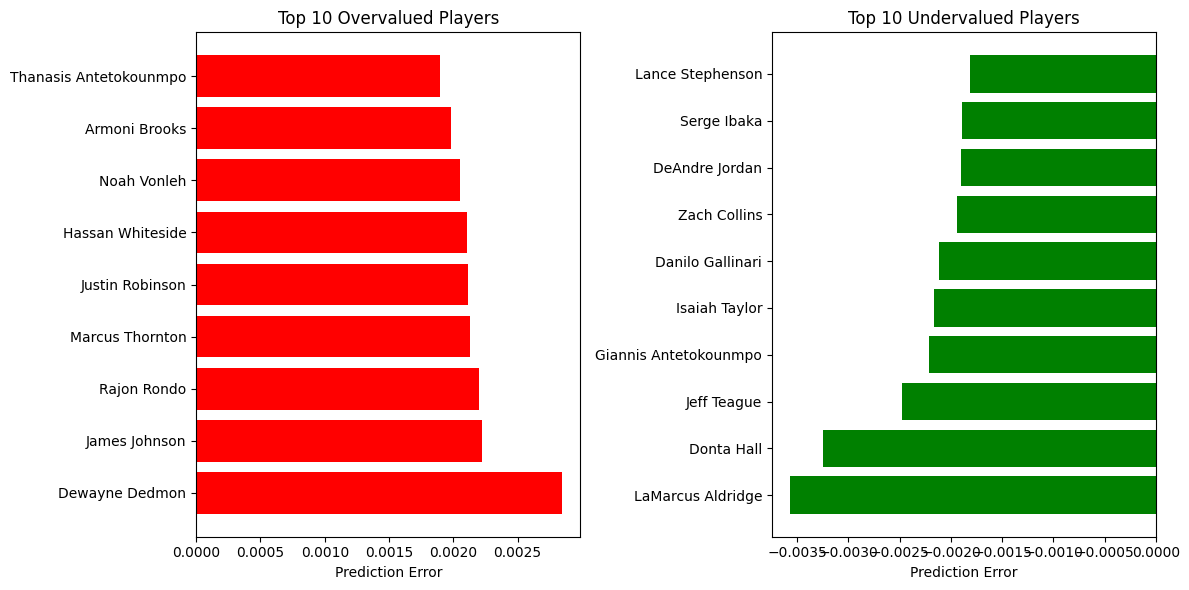

In [147]:
# Add prediction results to the test dataframe
test_contract_df = contract_df.iloc[test_index].copy()
test_contract_df['error'] = np.array(actuals) - np.array(predictions)
test_contract_df['predicted_salary_to_cap'] = predictions
test_contract_df['actual_salary_to_cap'] = actuals

# Sort by error to find top overvalued and undervalued players
overvalued = test_contract_df.sort_values(by='error', ascending=False).head(10)
undervalued = test_contract_df.sort_values(by='error').head(10)

print("Top 10 Overvalued Players:")
print(overvalued[['name', 'past_salary_to_cap', 'current_salary_to_cap', 'predicted_salary_to_cap', 'error']])

print("\nTop 10 Undervalued Players:")
print(undervalued[['name', 'past_salary_to_cap', 'current_salary_to_cap', 'predicted_salary_to_cap', 'error']])

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(overvalued['name'], overvalued['error'], color='red')
plt.xlabel('Prediction Error')
plt.title('Top 10 Overvalued Players')

plt.subplot(1, 2, 2)
plt.barh(undervalued['name'], undervalued['error'], color='green')
plt.xlabel('Prediction Error')
plt.title('Top 10 Undervalued Players')

plt.tight_layout()
plt.show()

Feature Importances:
past_TRB: 4.04%
past_eFG%: 3.96%
past_GS: 3.83%
past_PTS: 3.81%
past_3PA: 3.77%
past_salary_to_cap: 3.75%
past_ORB: 3.67%
past_FG: 3.62%
past_2PA: 3.59%
past_DRB: 3.57%
past_3P: 3.54%
past_FGA: 3.51%
past_2P: 3.43%
past_FG%: 3.37%
past_MP: 3.36%
past_FTA: 3.21%
past_FT: 3.16%
past_STL: 3.15%
past_salary_cap: 3.06%
past_TOV: 3.02%
past_AST: 2.98%
past_salary: 2.95%
past_stats: 2.90%
past_2P%: 2.87%
past_3P%: 2.77%
past_PF: 2.75%
past_G: 2.74%
debut_diff: 2.53%
past_BLK: 2.50%
past_FT%: 2.43%
current_salary_cap: 2.15%


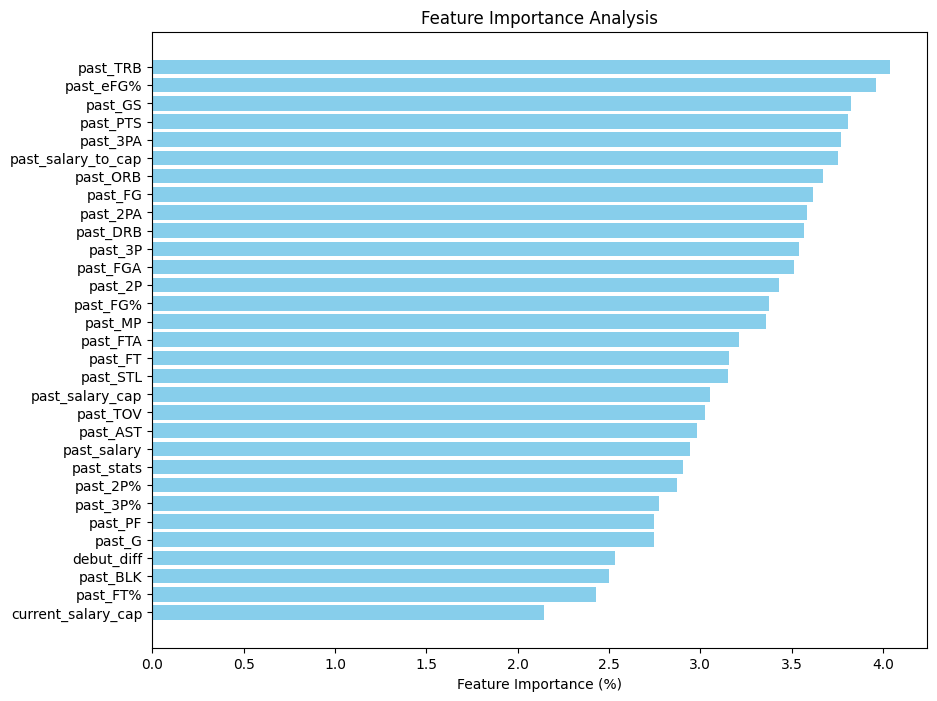

In [158]:
# Feature importance analysis function
def feature_importance(model, X):
    model.eval()
    baseline_pred = model(X).detach().numpy()
    feature_importances = []
    for i in range(X.shape[1]):
        X_permuted = X.clone()
        X_permuted[:, i] = torch.randn(X_permuted[:, i].shape)
        permuted_pred = model(X_permuted).detach().numpy()
        importance = np.mean(np.abs(baseline_pred - permuted_pred))
        feature_importances.append(importance)
    return np.array(feature_importances).reshape(-1, 1)


# Calculate feature importance
X_all_scaled = scaler.transform(X)
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)
# Calculate feature importance
feature_importances = feature_importance(model, X_all_tensor)

# Normalize to percentages
feature_importances_percentage = (feature_importances / feature_importances.sum()) * 100

# Output feature importance
features = contract_df.drop(columns=['current_salary_to_cap', 'current_contract_year', 'name', 'current_salary','past_contract_year',]).columns.tolist()
importance_df = pd.DataFrame(feature_importances_percentage, index=features, columns=['Importance'])

# Sort by importance and visualize
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importances as percentages
print("Feature Importances:")
for feature, importance in importance_df.itertuples():
    print(f"{feature}: {importance:.2f}%")

# Visualize the results
plt.figure(figsize=(10, 8))
plt.barh(importance_df.index, importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importance Analysis')
plt.gca().invert_yaxis()
plt.show()